In [1]:
import torch
print('CUDA版本:',torch.version.cuda)
print('cuDNN版本:',torch.backends.cudnn.version())
print('Pytorch版本:',torch.__version__)
print('显卡是否可用:','可用' if(torch.cuda.is_available()) else '不可用')
print('显卡数量:',torch.cuda.device_count())
print('是否支持BF16数字格式:','支持' if (torch.cuda.is_bf16_supported()) else '不支持')
print('当前显卡型号:',torch.cuda.get_device_name())
print('当前显卡的CUDA算力:',torch.cuda.get_device_capability())
print('当前显卡的总显存:',torch.cuda.get_device_properties(0).total_memory/1024/1024/1024,'GB')
print('是否支持TensorCore:','支持' if (torch.cuda.get_device_properties(0).major >= 7) else '不支持')
print('当前显卡的显存使用率:',torch.cuda.memory_allocated(0)/torch.cuda.get_device_properties(0).total_memory*100,'%')

CUDA版本: 12.1
cuDNN版本: 8801
Pytorch版本: 2.1.2+cu121
显卡是否可用: 可用
显卡数量: 1
是否支持BF16数字格式: 支持
当前显卡型号: NVIDIA GeForce RTX 3070 Laptop GPU
当前显卡的CUDA算力: (8, 6)
当前显卡的总显存: 7.99951171875 GB
是否支持TensorCore: 支持
当前显卡的显存使用率: 0.0 %


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

In [3]:
class Config:

    def __init__(self):
        
        # 初始化数据集参数
        self.data_path = 'data/days/all_day_data.csv'
        self.drop_column = ['Date']
        self.label = 'Close'
        self.seq_len = 4
        # self.mode = {'train':'train', 'val':'val', 'test':'test'}
        self.train_split = 0.8
        self.test_split = 0.1      
        self.val_split = 1 - self.train_split - self.test_split
        # 此处应写 train + val + test > 1的异常
        
        # 初始化模型参数
        self.data_last_dim_len = self.load_data_last_dim_len()
        # self.n_vocab = self.load_data_last_dim_len()
        # self.embed_size = [6]
        self.input_size = [6, 1]
        self.lstm_hidden_size = [128, 128]
        self.lstm_num_layers = [1, 1]
        self.lstm_dropout = 0.2
        self.is_bidirectional = False
        self.layer_dropout = 0.5
        self.dense_size = [32]
        self.output_size = 1

        # 初始化训练参数
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.batch_size = 32
        self.is_shuffle = True

        self.learn_rate = 0.2
        self.train_epochs = 1
        

    def load_data_last_dim_len(self):

        table = pd.read_csv(self.data_path)

        for drop_col in self.drop_column:

            table = table.drop(drop_col, axis=1)

        tb = np.array(table)
        
        # print(tb.shape[tb.ndim - 1])
        return tb.shape[tb.ndim - 1]

In [4]:
# print(len(torch.tensor([])))
a = torch.tensor([[1,2]]).float()
print(a.shape)
print(a.mean(1))
print(a.var(1, unbiased=False))
print(nn.functional.layer_norm(a,(2,)))

torch.Size([1, 2])
tensor([1.5000])
tensor([0.2500])
tensor([[-1.0000,  1.0000]])


In [5]:
a = torch.tensor([1,2,3,4])
print(a.shape)
print(a[1:])

torch.Size([4])
tensor([2, 3, 4])


In [6]:
class PriceData(Dataset):

    def __init__(self, cfg, mode):

        super(PriceData, self).__init__()

        self.data_path = cfg.data_path  
        self.ori_sample_num = 0

        self.feature_mean = []
        self.feature_var = []                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

        self.datas, self.labels = self.load_data(cfg)

        self.train_split, self.val_split, self.test_split = 0, 0, 0
        
        print('feature_mean.len:', len(self.feature_mean), len(self.feature_var))

        # print(self.datas.size(), len(self.labels))

        if mode == 'train':

            self.datas = self.datas[:int(len(self.datas) * cfg.train_split)]
            self.labels = self.labels[:int(len(self.labels) * cfg.train_split)]

        elif mode == 'validation':

            self.datas = self.datas[int(len(self.datas) * cfg.train_split) 
                : int(len(self.datas) * (cfg.train_split + cfg.test_split))]
            self.labels = self.labels[int(len(self.labels) * cfg.train_split) 
                : int(len(self.labels) * (cfg.train_split + cfg.test_split))]
            
        elif mode == 'test':

            self.datas = self.datas[int(
                len(self.datas) * (cfg.train_split + cfg.val_split)):]
            self.labels = self.labels[int(
                len(self.labels) * (cfg.train_split + cfg.val_split)):]

            self.test_mean = self.feature_mean[
                int(len(self.feature_mean) * (cfg.train_split + cfg.val_split)):]
            self.test_var = self.feature_var[
                int(len(self.feature_var) * (cfg.train_split + cfg.val_split)):]
            
            print('test_feature.len:', len(self.test_mean), len(self.test_var))

        print('!!!', mode, 'dataset_info:', len(self.datas), self.datas.shape,
              'label_info:', len(self.labels), self.labels.shape)


    def __getitem__(self, index):

        data, label = self.datas[index], self.labels[index]

        return data, label
    

    def __len__(self):

        return len(self.datas)
    

    def load_data(self, cfg):

        table = pd.read_csv(cfg.data_path)

        for drop_col in cfg.drop_column:

            table = table.drop(drop_col, axis=1)

        label_idx = table.columns.get_loc(cfg.label)
        print('label_idx:', label_idx)

        self.ori_sample_num = len(table)
        print(
            'ori_table.len:', len(table), 
            '\nori_table.columns:', len(table.columns), 'table.col_name:', table.columns,
            '\nori_table.values:', len(table.values),
            '\nori_table.shape:', table.shape
        )

        table = torch.tensor(np.array(table)).float()
        self.feature_mean = table.mean(1)[cfg.seq_len - 1:]
        self.feature_var = table.var(1, unbiased=False)[cfg.seq_len - 1:]
        table = nn.functional.layer_norm(table, (6,))
        print('table.type:', type(table), 'table.shape:', table.shape)

        datas = torch.tensor([])
        labels = torch.tensor([])
        # features_amount = len(table.columns)

        for index in range(len(table) - cfg.seq_len + 1):
            
            # datas.append(table[index : index + cfg.seq_len])
            # labels.append(table[cfg.label][index + cfg.seq_len])
            if len(datas) == 0 and len(labels) == 0:

                datas = table[index : index + cfg.seq_len, :].unsqueeze(0)
                # print('datas.shape', datas.shape)
                # print('datas.len:', len(datas))

                labels = table[index + cfg.seq_len - 1, label_idx].view(1)
                # print('labels.shape:', labels.shape)
                # print('++datas', datas, '++label',labels)
            
            else:

                datas = torch.cat(
                    [datas, table[index : index + cfg.seq_len, :].unsqueeze(0)], 
                    dim=0
                )

                labels = torch.cat(
                    [labels, table[index + cfg.seq_len - 1, label_idx].view(1)], 
                    dim=0
                )
                # print('datas.shape:', datas.shape)
                # print('++datas', datas, '++label',labels)

                # datas.append(table[index : index + cfg.seq_len, :])
                # labels.append(table[index + cfg.seq_len, label_idx])

            # print(datas)
            # print(labels)

            # if len(datas) == 2 :
            #     break

        print('datas.type:', type(datas[0]), type(labels))

        # datas = torch.tensor(np.array(datas)).float()
        
        # labels = torch.tensor(np.array(labels)).float()

        # print('ori_data_set.shape:', datas.shape, 'labels.shape:', labels.shape)

        print('ori_data_set.shape:', datas.shape, 'labels.shape:', labels.shape, labels)

        return datas, labels


In [7]:
cfg = Config()
# db = PriceData(cfg, 'train')
# db = PriceData(cfg, 'validation')
db = PriceData(cfg, 'test')

# a = [0, 1, 2, 3, 4, 5, 6, 7]
# print(a[:-9])
# j = 4
# for i in range(len(a) - j + 1):
#     print(a[i:i+j])
print('+++++++++++++++++')
for x, y in db:
    print(x, y)
    break
del db

label_idx: 0
ori_table.len: 8952 
ori_table.columns: 6 table.col_name: Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Fluctuation'], dtype='object') 
ori_table.values: 8952 
ori_table.shape: (8952, 6)
table.type: <class 'torch.Tensor'> table.shape: torch.Size([8952, 6])
datas.type: <class 'torch.Tensor'> <class 'torch.Tensor'>
ori_data_set.shape: torch.Size([8949, 4, 6]) labels.shape: torch.Size([8949]) tensor([ 0.7071,  0.6978,  0.6911,  ..., -0.2671, -0.2898, -0.2930])
feature_mean.len: 8949 8949
test_feature.len: 895 895
!!! test dataset_info: 895 torch.Size([895, 4, 6]) label_info: 895 torch.Size([895])
+++++++++++++++++
tensor([[-0.2894, -0.2783, -0.2752, -0.2994,  2.1556, -1.0133],
        [-0.2752, -0.2813, -0.2674, -0.2881,  2.1485, -1.0365],
        [-0.0938, -0.0926, -0.0743, -0.1070,  1.9011, -1.5334],
        [ 0.0564,  0.0997,  0.1013,  0.0372,  1.5749, -1.8695]]) tensor(0.0564)


In [8]:
def data_loader(data, cfg):

    return DataLoader(
        data,
        batch_size=cfg.batch_size,
        shuffle=cfg.is_shuffle,
        # num_workers= 4
    )

In [9]:
if __name__ == '__main__':

    cfg = Config()
    db = PriceData(cfg, 'validation')
    # db = PriceData(cfg, 'validation')
    # db = PriceData(cfg, 'test')

    train_data = data_loader(db, cfg)

    for i, batch in enumerate(train_data):

        data, label = batch
        print('i_data.shape:', data.shape, 'i_label.shape:', label.shape)
        print(data[0])

        # embed = nn.Embedding(6,2)
        # print(embed(data))

        break

    del db, cfg, train_data, data, label, batch
    # dataloader = DataLoader(db, batch_size=2)

    # for i, batch in enumerate(dataloader):

    #     print(batch)

    # del cfg, db, dataloader

label_idx: 0
ori_table.len: 8952 
ori_table.columns: 6 table.col_name: Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Fluctuation'], dtype='object') 
ori_table.values: 8952 
ori_table.shape: (8952, 6)
table.type: <class 'torch.Tensor'> table.shape: torch.Size([8952, 6])
datas.type: <class 'torch.Tensor'> <class 'torch.Tensor'>
ori_data_set.shape: torch.Size([8949, 4, 6]) labels.shape: torch.Size([8949]) tensor([ 0.7071,  0.6978,  0.6911,  ..., -0.2671, -0.2898, -0.2930])
feature_mean.len: 8949 8949
!!! validation dataset_info: 895 torch.Size([895, 4, 6]) label_info: 895 torch.Size([895])
i_data.shape: torch.Size([32, 4, 6]) i_label.shape: torch.Size([32])
tensor([[ 0.6602,  0.6844,  0.7022,  0.6467, -0.8189, -1.8746],
        [-0.3238, -0.3171, -0.3128, -0.3296,  2.1851, -0.9019],
        [-0.2723, -0.2759, -0.2691, -0.2863,  2.1465, -1.0430],
        [-0.2620, -0.2729, -0.2578, -0.2797,  2.1389, -1.0665]])


In [10]:
import torch.nn as nn
from torch import optim
from torcheval.metrics.functional import r2_score

In [11]:
class Predict(nn.Module):

    def __init__(self, cfg):

        super(Predict, self).__init__()

        self.layer_norm = nn.LayerNorm(cfg.data_last_dim_len)

        # self.embedding = nn.Embedding(cfg.n_vocab, cfg.embed_size)

        self.lstm1 = nn.LSTM(
            # cfg.embed_size,
            cfg.input_size[0],
            cfg.lstm_hidden_size[0],
            cfg.lstm_num_layers[0],
            bidirectional=cfg.is_bidirectional,
            # dropout=cfg.lstm_dropout
        )

        self.lstm2 = nn.LSTM(
            # cfg.embed_size,
            cfg.input_size[1],
            cfg.lstm_hidden_size[1],
            cfg.lstm_num_layers[1],
            bidirectional=cfg.is_bidirectional,
            # dropout=cfg.lstm_dropout
        )

        self.dropout = nn.Dropout(cfg.layer_dropout)
        
        self.dense1 = nn.Linear(cfg.lstm_hidden_size[1], cfg.dense_size[0])
        self.dense2 = nn.Linear(cfg.dense_size[0], cfg.output_size)

        self.relu = nn.ReLU(inplace=True)
        

    def forward(self, x):
        
        # print('input_dataset.type:', x.type())
        # norm = self.layer_norm(x)
        # print('norm.type:', norm.size())
        lstm1, _ = self.lstm1(x)
        # print('lstm1.type:', lstm1.size())
        dropout1 = self.dropout(lstm1)
        # print('dropout1.type:', dropout1.size())
        lstm2, _ = self.lstm2(dropout1)
        # print('lstm2.type:', lstm2.size())
        lstm_last = lstm2[:, -1, :]
        # print('lstm_last.type:', lstm_last.size())
        dropout2 = self.dropout(lstm_last)
        # print('dropout2.type:', dropout2.size())
        fc1 = self.dense1(dropout2)
        # print('fc1.type:', fc1.size())
        # fc1 = self.dropout1(fc1)
        rl_out = self.relu(fc1)
        # print('rl_out.type:', rl_out.size())
        out = self.dense2(rl_out).squeeze()
        # print('out.type:', out.size())

        # out = self.layer_norm(x)
        # out, _ = self.lstm1(out)
        # out = self.dropout1(out)
        # out, _ = self.lstm2(out)
        # out = self.dropout2(out)
        # out = self.dense1(out)
        # out = self.relu(out)
        # out = self.dense2(out)

        return out
        


In [12]:
class Config:

    def __init__(self):
        
        # 初始化数据集参数
        self.data_path = 'data/days/all_day_data.csv'
        self.drop_column = ['Date']
        self.label = 'Close'
        self.seq_len = 4
        # self.mode = {'train':'train', 'val':'val', 'test':'test'}
        self.train_split = 0.8
        self.test_split = 0.1      
        self.val_split = 1 - self.train_split - self.test_split
        # 此处应写 train + val + test > 1的异常
        
        # 初始化模型参数
        self.data_last_dim_len = self.load_data_last_dim_len()
        # self.n_vocab = self.load_data_last_dim_len()
        # self.embed_size = [6]
        self.input_size = [6, 128]
        self.lstm_hidden_size = [128, 128]
        self.lstm_num_layers = [1, 1]
        self.lstm_dropout = 0.2
        self.is_bidirectional = False
        self.layer_dropout = 0.5
        self.dense_size = [32]
        self.output_size = 1

        # 初始化训练参数
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.batch_size = 32
        self.is_shuffle = True

        self.learn_rate = 0.001
        self.train_epochs = 100
        

    def load_data_last_dim_len(self):

        table = pd.read_csv(self.data_path)

        for drop_col in self.drop_column:

            table = table.drop(drop_col, axis=1)

        tb = np.array(table)
        
        # print(tb.shape[tb.ndim - 1])
        return tb.shape[tb.ndim - 1]

In [13]:
cfg = Config()
# print(cfg.device)
model = Predict(cfg)
model.to(cfg.device)
print(model)

Predict(
  (layer_norm): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
  (lstm1): LSTM(6, 128)
  (lstm2): LSTM(128, 128)
  (dropout): Dropout(p=0.5, inplace=False)
  (dense1): Linear(in_features=128, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU(inplace=True)
)


In [14]:
def model_structure(model):
    blank = ' '
    print('-' * 90)
    print('|' + ' ' * 11 + 'weight name' + ' ' * 10 + '|' \
          + ' ' * 15 + 'weight shape' + ' ' * 15 + '|' \
          + ' ' * 3 + 'number' + ' ' * 3 + '|')
    print('-' * 90)
    num_para = 0
    type_size = 1  # 如果是浮点数就是4

    for index, (key, w_variable) in enumerate(model.named_parameters()):
        if len(key) <= 30:
            key = key + (30 - len(key)) * blank
        shape = str(w_variable.shape)
        if len(shape) <= 40:
            shape = shape + (40 - len(shape)) * blank
        each_para = 1
        for k in w_variable.shape:
            each_para *= k
        num_para += each_para
        str_num = str(each_para)
        if len(str_num) <= 10:
            str_num = str_num + (10 - len(str_num)) * blank

        print('| {} | {} | {} |'.format(key, shape, str_num))
    print('-' * 90)
    print('The total number of parameters: ' + str(num_para))
    print('The parameters of Model {}: {:4f}M'.format(model._get_name(), num_para * type_size / 1000 / 1000))
    print('-' * 90)

model_structure(model)

------------------------------------------------------------------------------------------
|           weight name          |               weight shape               |   number   |
------------------------------------------------------------------------------------------
| layer_norm.weight              | torch.Size([6])                          | 6          |
| layer_norm.bias                | torch.Size([6])                          | 6          |
| lstm1.weight_ih_l0             | torch.Size([512, 6])                     | 3072       |
| lstm1.weight_hh_l0             | torch.Size([512, 128])                   | 65536      |
| lstm1.bias_ih_l0               | torch.Size([512])                        | 512        |
| lstm1.bias_hh_l0               | torch.Size([512])                        | 512        |
| lstm2.weight_ih_l0             | torch.Size([512, 128])                   | 65536      |
| lstm2.weight_hh_l0             | torch.Size([512, 128])                   | 65536      |

In [15]:
# from torchsummary import summary

# # summary(model, (1823, 4, 6))
# model1 = Predict(cfg)
# summary(model1,(1823, 4, 6),device='cpu')
# del model1

In [16]:
# from torchstat import stat

# stat(model, (1823, 4, 6))

In [17]:
for name, module in model.named_modules():
    print('modules:', name, '--', module)

modules:  -- Predict(
  (layer_norm): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
  (lstm1): LSTM(6, 128)
  (lstm2): LSTM(128, 128)
  (dropout): Dropout(p=0.5, inplace=False)
  (dense1): Linear(in_features=128, out_features=32, bias=True)
  (dense2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU(inplace=True)
)
modules: layer_norm -- LayerNorm((6,), eps=1e-05, elementwise_affine=True)
modules: lstm1 -- LSTM(6, 128)
modules: lstm2 -- LSTM(128, 128)
modules: dropout -- Dropout(p=0.5, inplace=False)
modules: dense1 -- Linear(in_features=128, out_features=32, bias=True)
modules: dense2 -- Linear(in_features=32, out_features=1, bias=True)
modules: relu -- ReLU(inplace=True)


In [18]:
for name, m in model.named_children():
    print(name, '>>>', m)

layer_norm >>> LayerNorm((6,), eps=1e-05, elementwise_affine=True)
lstm1 >>> LSTM(6, 128)
lstm2 >>> LSTM(128, 128)
dropout >>> Dropout(p=0.5, inplace=False)
dense1 >>> Linear(in_features=128, out_features=32, bias=True)
dense2 >>> Linear(in_features=32, out_features=1, bias=True)
relu >>> ReLU(inplace=True)


In [19]:
train_db = PriceData(cfg, 'train')
    # db = PriceData(cfg, 'validation')
    # db = PriceData(cfg, 'test')

train_loader = data_loader(train_db, cfg)

print('++++++++++++++++++++++++++++')
print('train.type', type(train_loader), len(train_loader))
for x, y in train_loader:
    print(x)
    print(y)
    break

label_idx: 0
ori_table.len: 8952 
ori_table.columns: 6 table.col_name: Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Fluctuation'], dtype='object') 
ori_table.values: 8952 
ori_table.shape: (8952, 6)
table.type: <class 'torch.Tensor'> table.shape: torch.Size([8952, 6])
datas.type: <class 'torch.Tensor'> <class 'torch.Tensor'>
ori_data_set.shape: torch.Size([8949, 4, 6]) labels.shape: torch.Size([8949]) tensor([ 0.7071,  0.6978,  0.6911,  ..., -0.2671, -0.2898, -0.2930])
feature_mean.len: 8949 8949
!!! train dataset_info: 7159 torch.Size([7159, 4, 6]) label_info: 7159 torch.Size([7159])
++++++++++++++++++++++++++++
train.type <class 'torch.utils.data.dataloader.DataLoader'> 224
tensor([[[-1.6983e-01, -7.6014e-02, -7.3342e-02, -1.7865e-01,  1.9525e+00,
          -1.4546e+00],
         [-6.3901e-02, -8.6157e-02, -4.6218e-02, -1.1756e-01,  1.8779e+00,
          -1.5640e+00],
         [-9.8371e-02, -1.0040e-01, -9.0842e-02, -1.3254e-01,  1.9236e+00,
          -1.5014e+00],
         [-7.

In [20]:
val_db = PriceData(cfg, 'validation')

val_loader = data_loader(val_db, cfg)
print('++')
print('val.type', type(val_loader), len(val_loader))

label_idx: 0
ori_table.len: 8952 
ori_table.columns: 6 table.col_name: Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Fluctuation'], dtype='object') 
ori_table.values: 8952 
ori_table.shape: (8952, 6)
table.type: <class 'torch.Tensor'> table.shape: torch.Size([8952, 6])
datas.type: <class 'torch.Tensor'> <class 'torch.Tensor'>
ori_data_set.shape: torch.Size([8949, 4, 6]) labels.shape: torch.Size([8949]) tensor([ 0.7071,  0.6978,  0.6911,  ..., -0.2671, -0.2898, -0.2930])
feature_mean.len: 8949 8949
!!! validation dataset_info: 895 torch.Size([895, 4, 6]) label_info: 895 torch.Size([895])
++
val.type <class 'torch.utils.data.dataloader.DataLoader'> 28


In [21]:
test_db = PriceData(cfg, 'test')
cfg.is_shuffle = False
test_loader = data_loader(test_db, cfg)
print('++')
print('test.type', type(test_loader), len(test_loader))

label_idx: 0
ori_table.len: 8952 
ori_table.columns: 6 table.col_name: Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Fluctuation'], dtype='object') 
ori_table.values: 8952 
ori_table.shape: (8952, 6)
table.type: <class 'torch.Tensor'> table.shape: torch.Size([8952, 6])
datas.type: <class 'torch.Tensor'> <class 'torch.Tensor'>
ori_data_set.shape: torch.Size([8949, 4, 6]) labels.shape: torch.Size([8949]) tensor([ 0.7071,  0.6978,  0.6911,  ..., -0.2671, -0.2898, -0.2930])
feature_mean.len: 8949 8949
test_feature.len: 895 895
!!! test dataset_info: 895 torch.Size([895, 4, 6]) label_info: 895 torch.Size([895])
++
test.type <class 'torch.utils.data.dataloader.DataLoader'> 28


In [22]:
optimizer = optim.Adam(model.parameters(), lr=cfg.learn_rate)
criteon = nn.MSELoss().to(cfg.device)

In [23]:
import visdom

viz = visdom.Visdom()

viz.line([0.], [0.], win='train_loss', opts=dict(title='train loss', legend=['loss']))
viz.line([0.], [0.], win='train_epoch_loss', opts=dict(title='train epoch loss', legend=['loss']))
viz.line([0.], [0.], win='validation_acc', opts=dict(title='validation acc', legend=['acc']))
# viz.line([0.], [-1.], win='train_loss_epoch', opts=dict(title='train loss&acc', legend=['loss', 'acc']))

# viz.line([loss.item()], [global_step], win='train_loss', update='append')

Setting up a new session...


'validation_acc'

In [24]:
def evaluate(model, loader, mode='train'):

    r2 = 0
    total = len(loader.dataset)
    pred = []

    for x, y in loader:

        x, y = x.to(cfg.device), y.to(cfg.device)
        # print('y', y)
        with torch.no_grad():
            logits = model(x)
        # print('logits', logits)
        # print('y', y)
        r2 += r2_score(logits, y).sum().float().item()
        # print(len(logits))

        if mode == 'untrain':
            
            for i in range(len(logits)):

                pred.append(logits[i].item())

    if mode == 'untrain':
        
        return r2 / total, pred

    return r2 / total

训练开始

In [25]:
global_step1 = 0
global_step2 = 0

best_r2 = -100
epoch_loss = 0

for epoch in range(cfg.train_epochs):

    print(epoch)
    model.train()
    for i, batch in enumerate(train_loader):

        data, label = batch
        data = data.to(cfg.device)
        label = label.to(cfg.device)
        # print('i_data.shape:', data.shape, 'i_label.shape:', label.shape)

        pred = model(data)
        loss = criteon(pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print('loss.item:',loss.item())
        
        viz.line([loss.item()], [global_step1], win='train_loss', update='append')
        global_step1 += 1

        # print(type(np.array(loss.item())))
        
        # if epoch % 10 == 0 and i % 32 == 0:
        #     print('loss:', loss)
        # break

    # break
    
    viz.line([loss.item()], [epoch], win='train_epoch_loss', update='append')

    model.eval()
    with torch.no_grad():
        
    #     evalute = 0
        
        for x, y in val_loader:
            
            r2 = evaluate(model, val_loader)

            if r2 > best_r2:

                best_r2 = r2
                best_epoch = epoch

                torch.save(model.state_dict(), 'best.mdl')

            # viz.line([torch.Tensor.cpu(r2)], [global_step2], win='validation_acc', update='append')
            viz.line([r2], [global_step2], win='validation_acc', update='append')
            global_step2 += 1

            # break

    # break

    # if epoch % 10 == 0 and i % 32 == 0:
    #     print('loss:', loss)



0


1
2
3
4
5
6
7
8


KeyboardInterrupt: 

In [ ]:
model.eval()
model.load_state_dict(torch.load('best.mdl'))

test_r2, pred = evaluate(model, test_loader, mode='untrain')

print(test_r2)
print(pred)

0.03124400004328296
[0.0581204779446125, 0.6769258975982666, -0.3587498962879181, -0.36508312821388245, -0.3563949763774872, -0.34820303320884705, -0.3112466335296631, -0.31925639510154724, -0.3140204846858978, -0.32339155673980713, -0.3305857479572296, -0.2968234121799469, 0.01571907103061676, -0.28718844056129456, -0.295108824968338, -0.29890039563179016, -0.28130942583084106, -0.28805670142173767, -0.2715419828891754, -0.21780513226985931, -0.04218318685889244, 0.6628239154815674, -0.3513283133506775, -0.3676476776599884, -0.35413655638694763, -0.3533041775226593, -0.39959973096847534, -0.4140951931476593, -0.3926048278808594, -0.3886653482913971, -0.3954160511493683, -0.37830230593681335, -0.38076141476631165, -0.38367754220962524, -0.39855194091796875, -0.3840389847755432, -0.38424593210220337, -0.37266507744789124, -0.35294806957244873, -0.3274063467979431, -0.3207414448261261, -0.30187371373176575, -0.16015905141830444, 0.5877596139907837, -0.3871459364891052, -0.418181747198104

In [ ]:
pred = torch.from_numpy(np.array(pred))
print(type(pred), pred.shape)
print(type(test_db.test_mean), test_db.test_mean.shape)
print(type(test_db.test_var), test_db.test_var.shape)

<class 'torch.Tensor'> torch.Size([895])
<class 'torch.Tensor'> torch.Size([895])
<class 'torch.Tensor'> torch.Size([895])


In [ ]:
def denormalize(value, mean, var):

    new_value = value * var.sqrt() + mean

    return new_value

denormalized_value = denormalize(pred, test_db.test_mean, test_db.test_var).numpy()
print(denormalized_value.size, denormalized_value.shape)
print(denormalized_value)

NameError: name 'pred' is not defined

In [ ]:
print(len(test_db.datas), len(test_db.labels))
print()

895 895



In [ ]:
table = pd.read_csv(cfg.data_path)
print(table['Close'][-len(test_db.datas):])

8057    58.29
8058    58.16
8059    54.45
8060    53.96
8061    55.28
        ...  
8947    80.11
8948    81.36
8949    79.87
8950    78.50
8951    79.63
Name: Close, Length: 895, dtype: float64


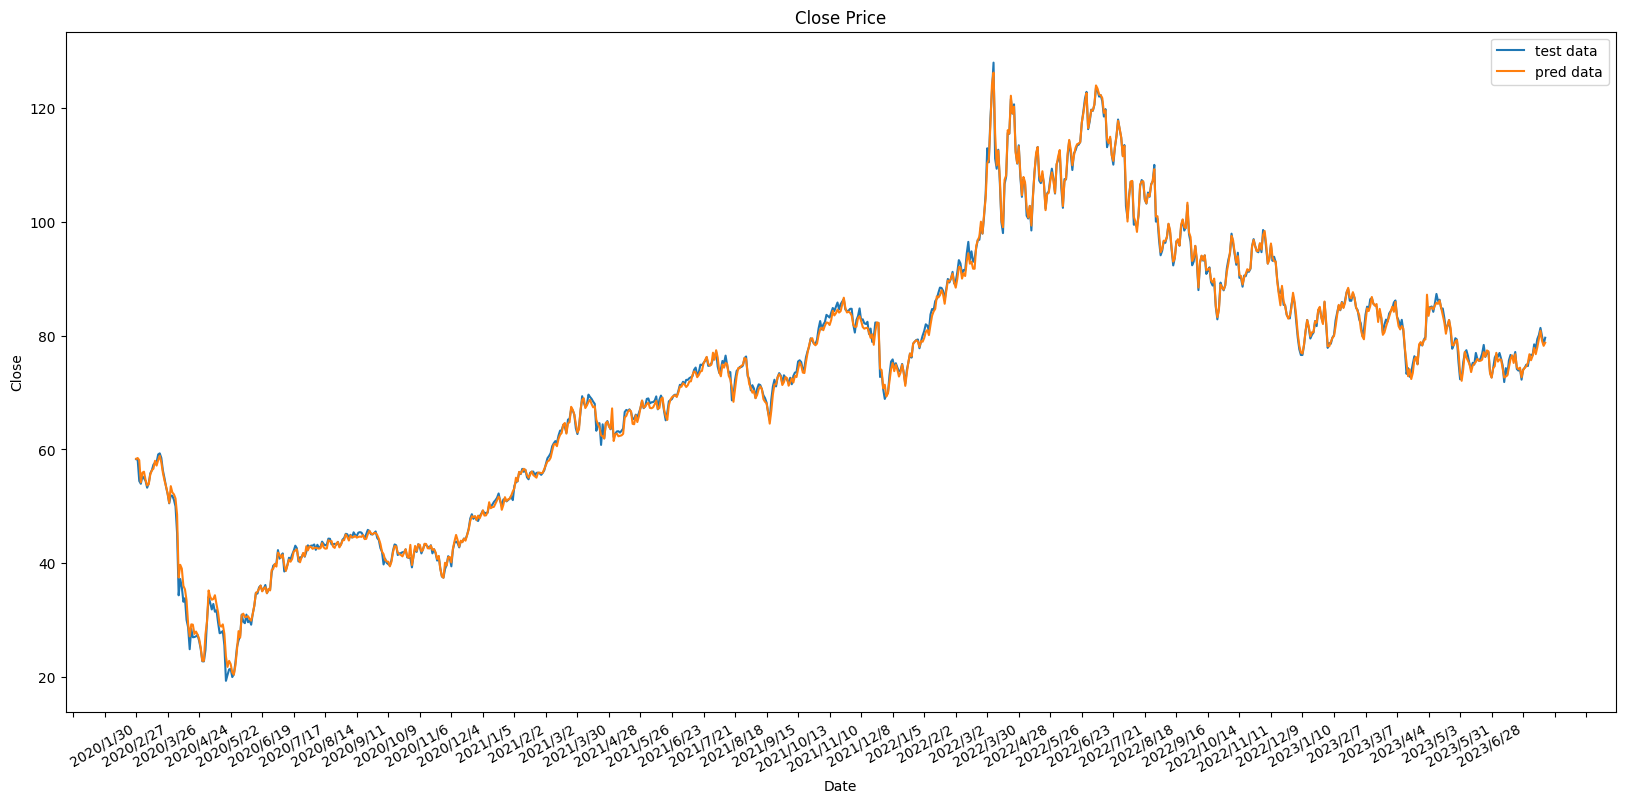

In [ ]:
import matplotlib.pyplot as plt

fig, ax0 = plt.subplots(figsize=(40,20))

# xdata = db['Date']

ax0.plot(table["Date"][-len(test_db.datas):], table["Close"][-len(test_db.datas):], label="test data")
ax0.plot(table["Date"][-len(test_db.datas):], denormalized_value, label="pred data")

ax0.xaxis.set_major_locator(plt.MultipleLocator(20))
fig.autofmt_xdate() #自动旋转xlabel

ax0.set_title("Close Price")
ax0.set_xlabel("Date")
ax0.set_ylabel("Close")

ax0.legend()

plt.show()

In [ ]:
from sklearn.metrics import r2_score
# R_2 = r2_score(y_test,prediction)
# print(R_2)

In [ ]:
from torchsummary import summary

# summary(model, (1823, 4, 6))
summary(model,(4, 6))
# del model0

AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
import torch
import torchvision
# 导入torchsummary
from torchsummary import summary

# 需要使用device来指定网络在GPU还是CPU运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 建立神经网络模型，这里直接导入已有模型
# model = model().to(device)
model = torchvision.models.vgg11_bn().to(device)
# 使用summary，注意输入维度的顺序
summary(model, input_size=(3, 224, 224))